<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c3_w4_shakespeare_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate --quiet \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [3]:
#@title Enable TPU
use_tpu = True #@param ["False", "True"] {type:"raw"}

if use_tpu:
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tpu_spec = tpu.cluster_spec().as_dict()['worker']
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU:', tpu_spec)
  except ValueError:
    print('ERROR: Not connected to a TPU.')
    raise BaseException('ERROR: Select use_tpu=False.')

INFO:tensorflow:Initializing the TPU system: grpc://10.51.85.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.51.85.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: ['10.51.85.154:8470']


In [4]:
tokenizer = Tokenizer()
with open("sonnets.txt") as f:
    data = f.read()
    corpus = data.lower().split("\n")
    tokenizer.fit_on_texts(corpus)
    
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(
    pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
)
predictiors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = to_categorical(label, num_classes=total_words)

In [8]:
def create_model():
    return Sequential([
        Embedding(total_words, 100, input_length=max_sequence_len - 1),
        Bidirectional(LSTM(150, return_sequences=True)),
        Dropout(0.2),
        LSTM(100),
        Dense(total_words/2, activation='relu', 
              kernel_regularizer=regularizers.l2(0.01)),
        Dense(total_words, activation='softmax')             
    ])

if use_tpu:
  with tpu_strategy.scope():
    model = create_model()
else:
  model = create_model()

In [9]:
model.compile(
    optimizer=Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [10]:
history = model.fit(predictiors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 24s 29ms/step - loss: 7.3215 - accuracy: 0.0212
Epoch 2/100
484/484 [==============================] - 10s 21ms/step - loss: 6.5042 - accuracy: 0.0225
Epoch 3/100
484/484 [==============================] - 10s 22ms/step - loss: 6.3967 - accuracy: 0.0233
Epoch 4/100
484/484 [==============================] - 10s 22ms/step - loss: 6.2753 - accuracy: 0.0318
Epoch 5/100
484/484 [==============================] - 11s 22ms/step - loss: 6.1889 - accuracy: 0.0338
Epoch 6/100
484/484 [==============================] - 10s 22ms/step - loss: 6.0939 - accuracy: 0.0372
Epoch 7/100
484/484 [==============================] - 10s 21ms/step - loss: 6.0407 - accuracy: 0.0371
Epoch 8/100
484/484 [==============================] - 10s 22ms/step - loss: 5.9212 - accuracy: 0.0403
Epoch 9/100
484/484 [==============================] - 10s 21ms/step - loss: 5.8340 - accuracy: 0.0439
Epoch 10/100
484/484 [==============================] - 10s 21ms/step - l

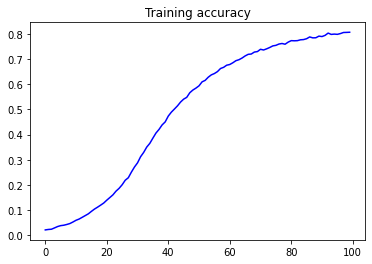

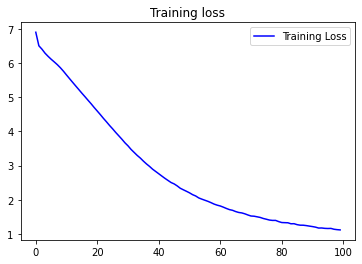

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [12]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope or worms well spent near flatter lie to none take dead rare ' so ' kill me so confounds men near mend truth lies men's pride lies deem'd torn young most deem'd rolling level of gone each fresh ornament now live more nearly rare rare spent young on crime twain dumb cold pain twain be free free torn free bright rare gone of pleasure heaven seen dyed seen lie on true art hell new now spent live dead aside skill painted way mother mother mother pain write so praise she remains grows say born of shame quite lie doth none
